In [1]:
import imp
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import glob
import cv2
import PIL
import matplotlib.pyplot as plt
from pyMLaux.functions import evaluate_classification_result, plot_history

# Kaggle Rome dataset base line: CO2 model
Check for GPU

In [2]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Basic constants

In [34]:
data_dir = "./../data/kaggle-rome-weather-dataset-resized"
batch_size = 16
number_images = 50
image_height = 224
image_width = 224
nr_color_channels = 3
seed = 2023

Create ImageDataGenerator for data augmentation of training data

In [35]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   fill_mode='constant',
                                   validation_split= 0.2,
                                   cval=0)

Get training data

In [36]:
img_train = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size,  subset='training', seed=seed,
                                                    class_mode='categorical')
img_train

Found 200 images belonging to 5 classes.


Get test data

In [37]:
img_test = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size,  subset='validation', seed=seed,
                                                    class_mode='categorical')
img_test

Found 50 images belonging to 5 classes.


Build model

In [38]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(image_width, image_height, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

Create model checkpoints

In [39]:
filepath = "./" + 'models/rome_co2/rome_co2_{epoch:02d}-{val_accuracy:.4f}.hdf5'
check_point = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')

In [40]:
callbacks_list = [check_point]

In [41]:
model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
                  metrics=['accuracy'])

In [42]:
history = model.fit(img_train,
                    steps_per_epoch=(len(img_train.filenames) // batch_size), 
                    epochs=25,
                    validation_data=img_test, 
                    validation_steps=(len(img_test.filenames) // batch_size),
                    callbacks=callbacks_list)

Epoch 1/25
12/12 [==============================] - 6s 323ms/step - loss: 1.6697 - accuracy: 0.3967 - val_loss: 1.7201 - val_accuracy: 0.2083

Epoch 00001: val_accuracy improved from -inf to 0.20833, saving model to ./models/rome_co2\rome_co2_01-0.2083.hdf5
Epoch 2/25
12/12 [==============================] - 3s 261ms/step - loss: 1.1229 - accuracy: 0.6467 - val_loss: 1.9523 - val_accuracy: 0.2083

Epoch 00002: val_accuracy did not improve from 0.20833
Epoch 3/25
12/12 [==============================] - 4s 314ms/step - loss: 0.9036 - accuracy: 0.6685 - val_loss: 2.3581 - val_accuracy: 0.2083

Epoch 00003: val_accuracy did not improve from 0.20833
Epoch 4/25
12/12 [==============================] - 4s 319ms/step - loss: 0.8673 - accuracy: 0.6739 - val_loss: 2.7026 - val_accuracy: 0.1875

Epoch 00004: val_accuracy did not improve from 0.20833
Epoch 5/25
12/12 [==============================] - 3s 276ms/step - loss: 0.7237 - accuracy: 0.7337 - val_loss: 3.2308 - val_accuracy: 0.1875

Epoch

Evaluate model

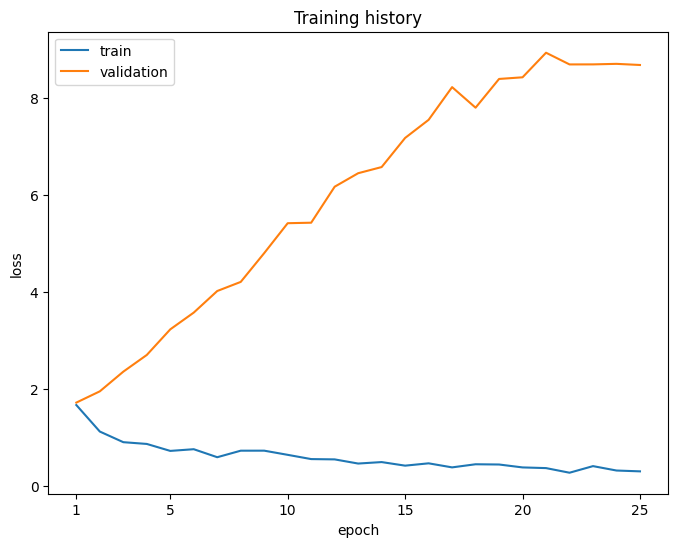

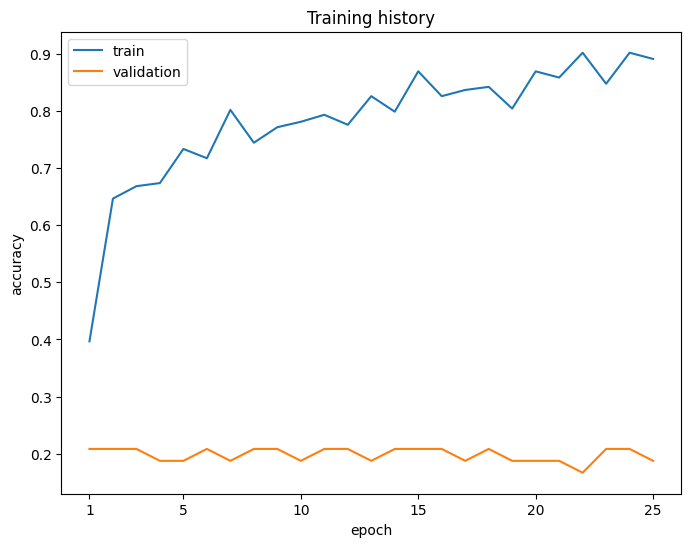

In [43]:
plot_history(history)

Load best model

In [44]:
model = keras.models.load_model("./models/rome_co2/rome_co2_01-0.2083.hdf5")
pred = model.predict(img_test, steps=len(img_test.filenames))

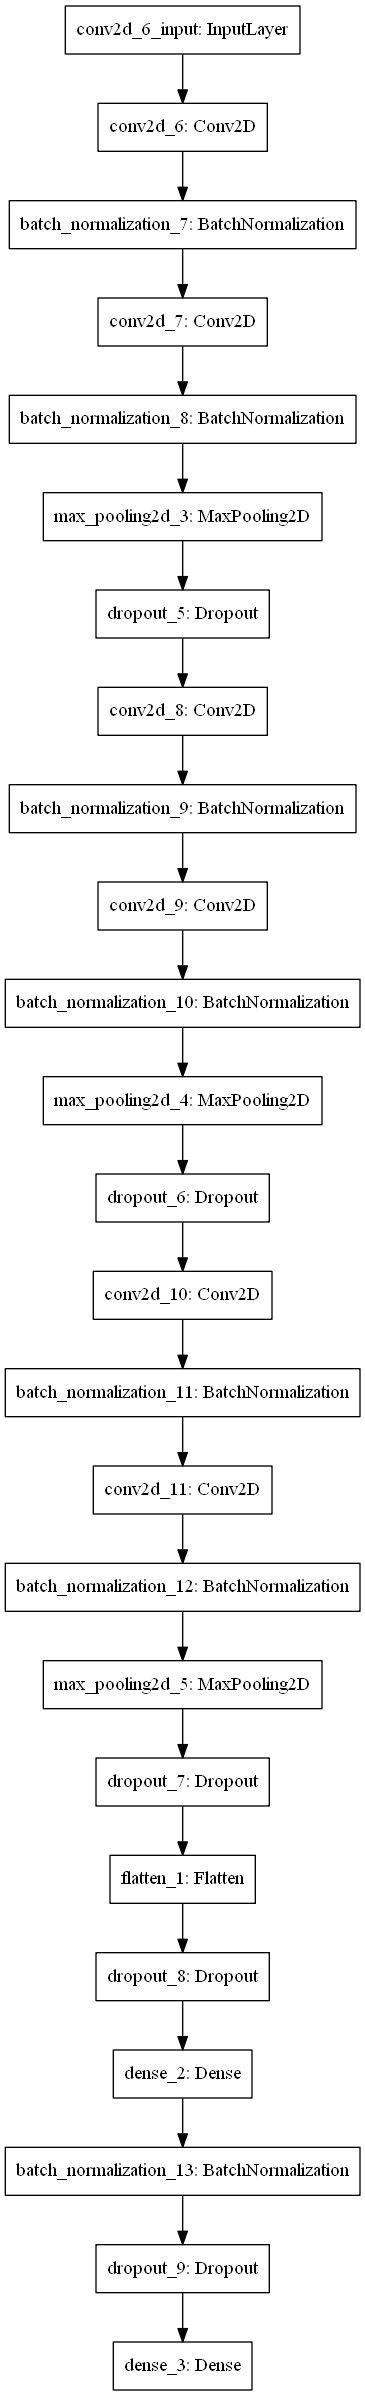

In [45]:
keras.utils.plot_model(model)

In [46]:
evaluate_classification_result(img_test.classes, pred,classes=["foggy","cloudy","sunny","snowy","rainy"])

[[ 0 10  0  0  0]
 [ 0 10  0  0  0]
 [ 0 10  0  0  0]
 [ 0 10  0  0  0]
 [ 0 10  0  0  0]]


Class foggy:
    Sensitivity (TPR):   0.000% (0 of 10)
    Specificity (TNR): 100.000% (40 of 40)
    Precision:             nan% (0 of 0)
    Neg. pred. value:   80.000% (40 of 50)
Class cloudy:
    Sensitivity (TPR): 100.000% (10 of 10)
    Specificity (TNR):   0.000% (0 of 40)
    Precision:          20.000% (10 of 50)
    Neg. pred. value:      nan% (0 of 0)
Class sunny:
    Sensitivity (TPR):   0.000% (0 of 10)
    Specificity (TNR): 100.000% (40 of 40)
    Precision:             nan% (0 of 0)
    Neg. pred. value:   80.000% (40 of 50)
Class snowy:
    Sensitivity (TPR):   0.000% (0 of 10)
    Specificity (TNR): 100.000% (40 of 40)
    Precision:             nan% (0 of 0)
    Neg. pred. value:   80.000% (40 of 50)
Class rainy:
    Sensitivity (TPR):   0.000% (0 of 10)
    Specificity (TNR): 100.000% (40 of 40)
    Precision:             nan% (0 of 0)
    Neg. pred. value:   80.000% (40 of 

c:\Users\selin\Desktop\cov-project\cov-project\ml\pyMLaux\functions.py:148: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp / (tp + fp)
c:\Users\selin\Desktop\cov-project\cov-project\ml\pyMLaux\functions.py:153: RuntimeWarning: invalid value encountered in double_scalars
  print('    Neg. pred. value:  %7.3f%% (%d of %d)'%(100. * tn / (tn + fn) , tn, tn + fn))


array([[ 0, 10,  0,  0,  0],
       [ 0, 10,  0,  0,  0],
       [ 0, 10,  0,  0,  0],
       [ 0, 10,  0,  0,  0],
       [ 0, 10,  0,  0,  0]], dtype=int64)